# 二手房交易分析

## 目标

通过数据分析，对后续二手房交易策略提供支持，计划进行如下维度分析

1. 小区户型交易热点，掌握哪些户型易于成交
2. 用户行为，户型与交易周期的关系，了解一个新挂的二手房，什么情况下可能成交，以及相应的议价空间
3. 交易趋势，确认政策对交易的量化影响，以及目前的价格走势

随后形成如下认知：

1. 户型后续出手难度
2. 户型定价策略，报价博弈策略
3. 潜在竞争客户应对策略

最终用户如下决策

1. 买什么户型
2. 报多少价格
3. 如何进行议价

# 结论模板

1. 交易热点：小区成交热点户型，面积，朝向，楼层
2. 交易趋势：成交均价随月份趋势和分布，挂牌价与成交价gap的均值和线框图
3. 交易行为：成交前平均带看次数和成交周期分布和趋势

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
pd.set_option("display.max_rows", None)
#pd.reset_option("display.max_rows")

# 一. 数据载入&预处理

In [3]:
# 载入数据
data = pd.read_csv('../教场口6号院.csv')

In [4]:
# 预览数据
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,listing_time,last_transaction_duration,transaction_price,history_trade_count,listed_price,transaction_duration,price_change_count,visit_count,follower_count,page_view_count
0,教场口6号院 1室1厅 50.92平米,2019.11.05,教场口6号院,1室1厅1厨1卫,中楼层(共6层),50.92㎡,板楼,南 北,2003,101105630684,2019-09-01,满五年,722,1,730,66,1,23,21,909
1,教场口6号院 1室1厅 54.66平米,2019.07,教场口6号院,1室1厅1厨1卫,底层(共6层),54.66㎡,板楼,南,2003,101104796571,2019-05-25,满五年,718-733,1,750,37,1,58,25,1332
2,教场口6号院 1室1厅 51.37平米,2019.07.09,教场口6号院,1室1厅1厨1卫,低楼层(共6层),51.37㎡,板楼,南 北,2003,101104489100,2019-04-13,暂无数据,719,1,740,88,1,18,34,1607


In [5]:
# 预览大小和特征数
data.shape

(211, 20)

In [6]:
#处理日期数据
data['deal_date'] = pd.to_datetime(data['deal_date'])
data['listing_time'] = pd.to_datetime(data['listing_time'], errors='coerce')
data['deal_month'] = data['deal_date'].dt.to_period('M').dt.to_timestamp()
data['deal_year'] = data['deal_date'].dt.to_period('Y').dt.to_timestamp()

In [7]:
# 转成整数类型日期
data['deal_month_num'] = data['deal_month'].dt.strftime('%Y%m')
data['deal_month_num'] = data['deal_month_num'].map(lambda x:int(x) if isinstance(x, str) else x)

In [8]:
data.dtypes

title                                object
deal_date                    datetime64[ns]
community                            object
house_type                           object
floor                                object
area                                 object
building_type                        object
orientation                          object
build_year                           object
lianjia_id                           object
listing_time                 datetime64[ns]
last_transaction_duration            object
transaction_price                    object
history_trade_count                   int64
listed_price                         object
transaction_duration                 object
price_change_count                    int64
visit_count                           int64
follower_count                        int64
page_view_count                      object
deal_month                   datetime64[ns]
deal_year                    datetime64[ns]
deal_month_num                  

In [9]:
# 处理数值型数据转换
# 成交周期
data['transaction_duration'] = data['transaction_duration'].map(lambda x: np.nan if x=='暂无数据' or x is np.nan else int(x)).astype('Int64',errors='ignore')
# 面积
data['area'] = data['area'].map(lambda x: float(x.strip('㎡') if x != '暂无数据' else np.nan))
# 成交价
def convert_int(numberStr):
    if isinstance(numberStr, int) or isinstance(numberStr, float):
        return numberStr
    if numberStr == '暂无数据':
        return np.nan
    elif '.' in numberStr:
        return int(numberStr.split('.')[0])
    elif '-' not in numberStr:
        return int(numberStr)
    else:
        low,up = numberStr.split('-')
        return int((int(low)+int(up))/2)
data['transaction_price'] = data['transaction_price'].map(convert_int)

# 挂牌价
data['listed_price'] = data['listed_price'].map(convert_int).astype('Int64')

# 浏览数
data['page_view_count'] = data['page_view_count'].map(convert_int).astype('Int64')

In [10]:
#处理字符串类型
# 朝向
data['orientation'] = data['orientation'].map(lambda x: ''.join(set([i for i in x if i != ' '])))

In [11]:
# 新列
# 每平米价格
data['per_area_price'] = data['transaction_price']/data['area']
# 成交价-报价
data['transaction_listed_price_gap'] = data['transaction_price']-data['listed_price']

def convert_area_level(area):
    return int(round(area/10))*10

def convert_room_count(house_type):
    try:
        return int(house_type[0])
    except Exception:
        return 0

# 面积阶梯
data['area_level'] = data['area'].map(convert_area_level)
# 房间数归一化
data['room_count'] = data['house_type'].map(convert_room_count)

In [12]:
data.dtypes

title                                   object
deal_date                       datetime64[ns]
community                               object
house_type                              object
floor                                   object
area                                   float64
building_type                           object
orientation                             object
build_year                              object
lianjia_id                              object
listing_time                    datetime64[ns]
last_transaction_duration               object
transaction_price                        int64
history_trade_count                      int64
listed_price                             Int64
transaction_duration                     Int64
price_change_count                       int64
visit_count                              int64
follower_count                           int64
page_view_count                          Int64
deal_month                      datetime64[ns]
deal_year    

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 27 columns):
title                           211 non-null object
deal_date                       211 non-null datetime64[ns]
community                       211 non-null object
house_type                      211 non-null object
floor                           211 non-null object
area                            211 non-null float64
building_type                   211 non-null object
orientation                     211 non-null object
build_year                      211 non-null object
lianjia_id                      211 non-null object
listing_time                    208 non-null datetime64[ns]
last_transaction_duration       211 non-null object
transaction_price               211 non-null int64
history_trade_count             211 non-null int64
listed_price                    202 non-null Int64
transaction_duration            145 non-null Int64
price_change_count              211 non-null int64

In [14]:
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,...,visit_count,follower_count,page_view_count,deal_month,deal_year,deal_month_num,per_area_price,transaction_listed_price_gap,area_level,room_count
0,教场口6号院 1室1厅 50.92平米,2019-11-05,教场口6号院,1室1厅1厨1卫,中楼层(共6层),50.92,板楼,北南,2003,101105630684,...,23,21,909,2019-11-01,2019-01-01,201911,14.179104,-8,50,1
1,教场口6号院 1室1厅 54.66平米,2019-07-01,教场口6号院,1室1厅1厨1卫,底层(共6层),54.66,板楼,南,2003,101104796571,...,58,25,1332,2019-07-01,2019-01-01,201907,13.263813,-25,50,1
2,教场口6号院 1室1厅 51.37平米,2019-07-09,教场口6号院,1室1厅1厨1卫,低楼层(共6层),51.37,板楼,北南,2003,101104489100,...,18,34,1607,2019-07-01,2019-01-01,201907,13.996496,-21,50,1


# 二. 数据分析

户型种类

In [15]:
print(data['house_type'].unique())

['1室1厅1厨1卫' '2室1厅1厨1卫' '- -室- -厅']


建成年代

In [16]:
print(data['build_year'].unique())

['2003' '未知']


## 2.1 交易行为

### 1）户型交易分布

可以查看交易主力户型和朝向

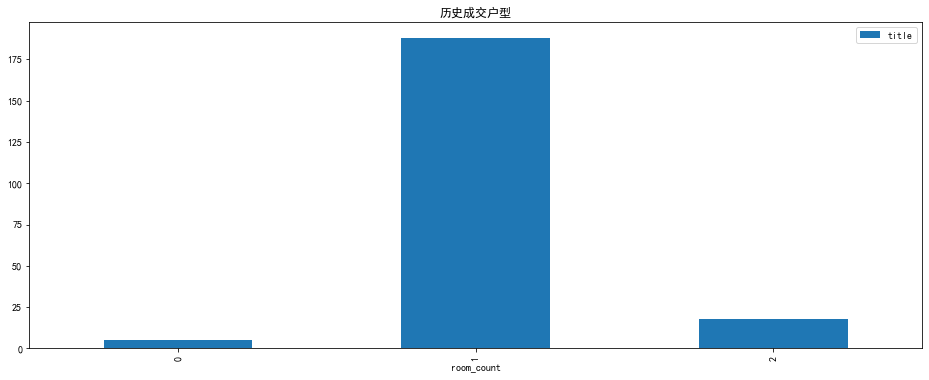

In [17]:
data.groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型')

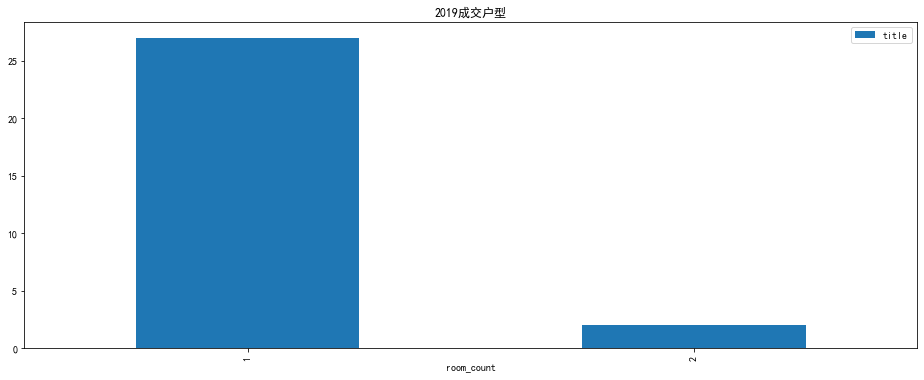

In [18]:
data[data['deal_date']>='2019'].groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交户型')

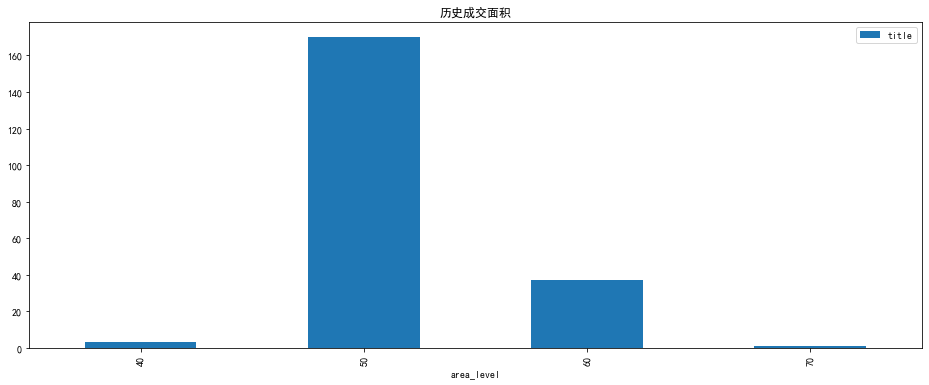

In [19]:
data.groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交面积')

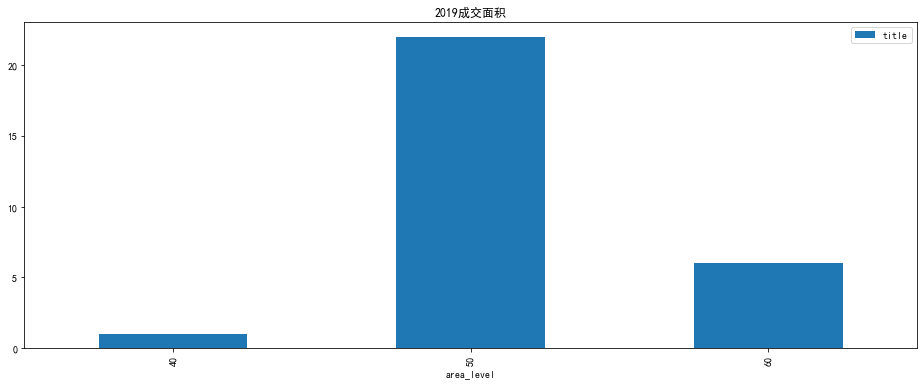

In [20]:
data[data['deal_date']>='2019'].groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交面积')

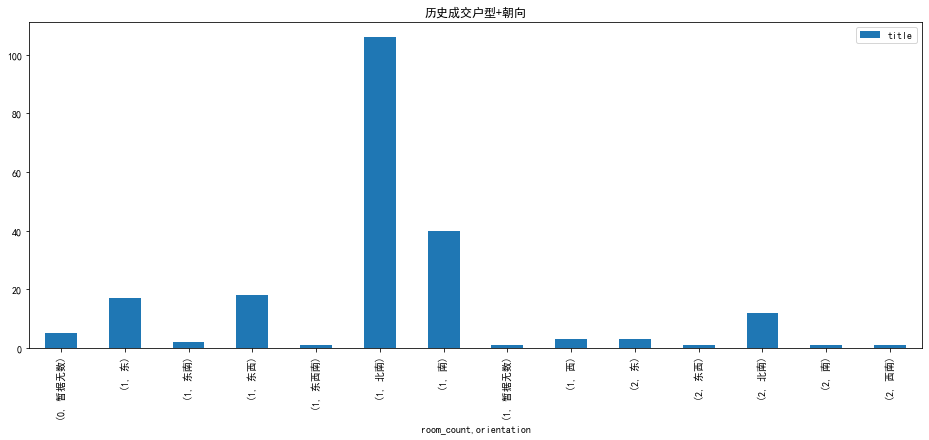

In [21]:
data.groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型+朝向')

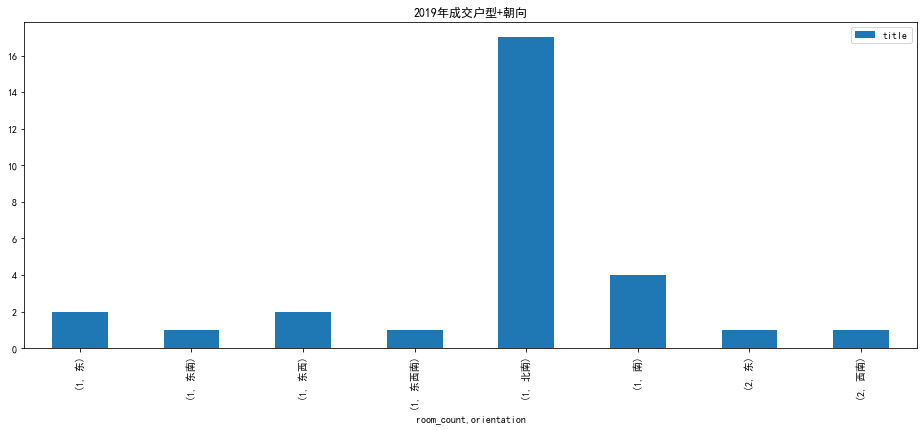

In [22]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交户型+朝向')

分户型朝向和楼层的成交分布

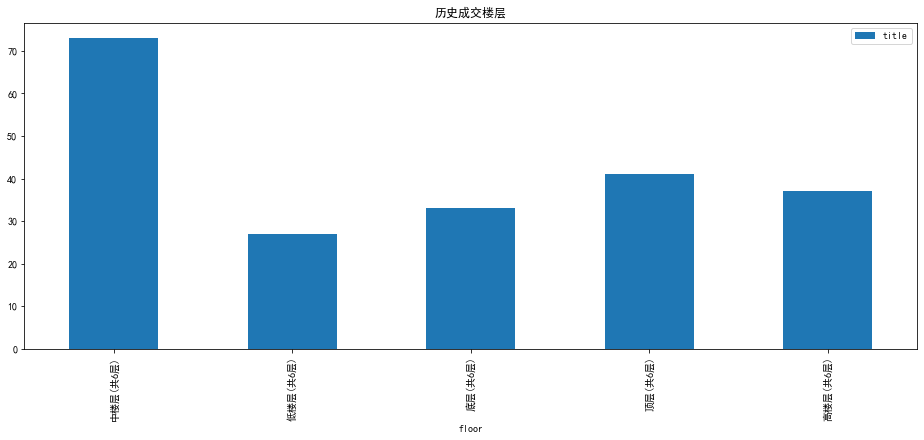

In [23]:
data.groupby(['floor']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交楼层')

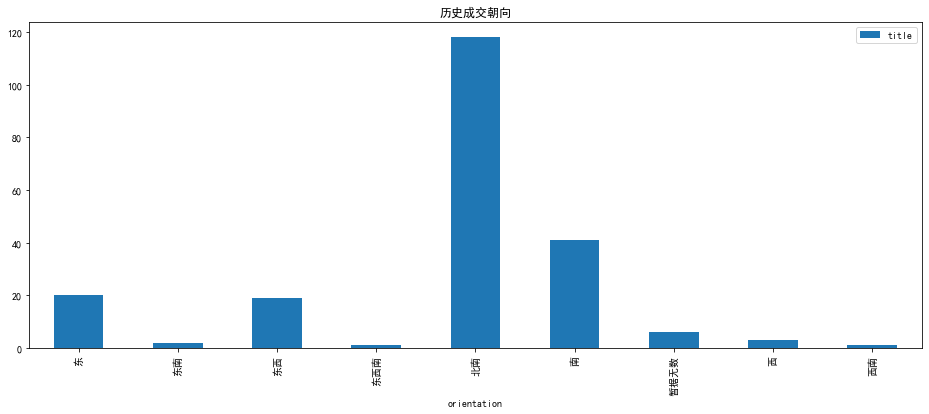

In [24]:
data.groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交朝向')

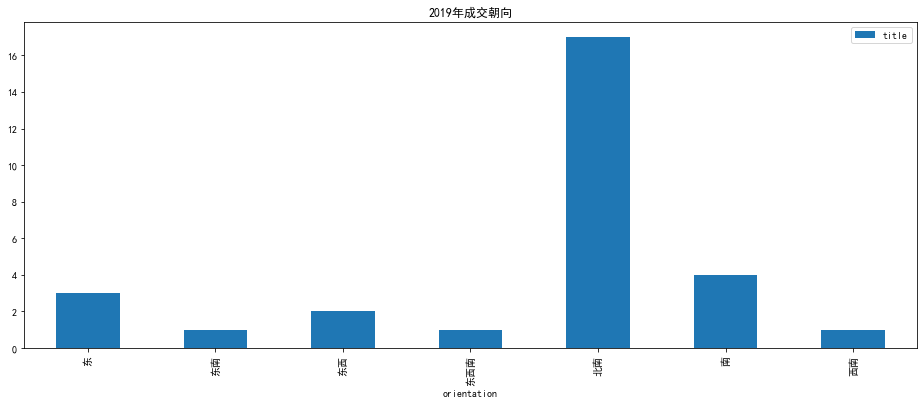

In [25]:
data[data['deal_date']>='2019'].groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交朝向')

In [26]:
data.groupby(['house_type','orientation','floor']).count()[['title']]

title
house_type orientation floor          
- -室- -厅   暂据无数        中楼层(共6层)      1
                       低楼层(共6层)      1
                       底层(共6层)       2
                       顶层(共6层)       1
1室1厅1厨1卫   东           中楼层(共6层)      7
                       低楼层(共6层)      5
                       顶层(共6层)       3
                       高楼层(共6层)      2
           东南          中楼层(共6层)      2
           东西          中楼层(共6层)      2
                       低楼层(共6层)      2
                       底层(共6层)       5
                       顶层(共6层)       3
                       高楼层(共6层)      6
           东西南         高楼层(共6层)      1
           北南          中楼层(共6层)     40
                       低楼层(共6层)     13
                       底层(共6层)      15
                       顶层(共6层)      21
                       高楼层(共6层)     17
           南           中楼层(共6层)     16
                       低楼层(共6层)      5
                       底层(共6层)       6
                       顶层(共6层)       7
                       高楼层(共6层)      6
           暂据无数        中楼层(共6层)      1
           西           顶层(共6层)       1
                       高楼层(共6层)      2
2室1厅1厨1卫   东           中楼层(共6层)      2
                       底层(共6层)       1
           东西          顶层(共6层)       1
           北南          中楼层(共6层)      1
                       低楼层(共6层)      1
                       底层(共6层)       4
                       顶层(共6层)       3
                       高楼层(共6层)      3
           南           顶层(共6层)       1
           西南          中楼层(共6层)      1

In [27]:
data.groupby(['area','orientation','floor']).count()[['title']]

title
area  orientation floor          
40.87 东           低楼层(共6层)      2
40.93 东西          底层(共6层)       1
50.15 东西          底层(共6层)       2
50.92 北南          中楼层(共6层)      1
                  低楼层(共6层)      1
                  底层(共6层)       1
                  顶层(共6层)       2
                  高楼层(共6层)      1
51.01 北南          中楼层(共6层)      1
                  顶层(共6层)       4
                  高楼层(共6层)      1
      暂据无数        顶层(共6层)       1
51.15 北南          低楼层(共6层)      1
                  底层(共6层)       1
51.16 北南          中楼层(共6层)      1
51.18 东西          顶层(共6层)       1
                  高楼层(共6层)      1
51.25 北南          中楼层(共6层)      2
                  低楼层(共6层)      1
                  底层(共6层)       2
                  高楼层(共6层)      3
      暂据无数        底层(共6层)       1
51.37 北南          中楼层(共6层)      4
                  低楼层(共6层)      1
                  高楼层(共6层)      1
51.67 北南          底层(共6层)       2
51.70 东西          中楼层(共6层)      1
                  底层(共6层)       1
      北南          高楼层(共6层)      1
51.77 东西          低楼层(共6层)      1
                  高楼层(共6层)      1
      北南          中楼层(共6层)      5
                  低楼层(共6层)      2
                  底层(共6层)       3
                  高楼层(共6层)      2
      暂据无数        中楼层(共6层)      1
51.78 北南          中楼层(共6层)      1
                  顶层(共6层)       1
                  高楼层(共6层)      2
51.87 北南          中楼层(共6层)      2
                  低楼层(共6层)      1
                  底层(共6层)       1
                  高楼层(共6层)      2
51.96 北南          中楼层(共6层)      2
                  底层(共6层)       2
                  顶层(共6层)       6
                  高楼层(共6层)      1
52.00 北南          底层(共6层)       1
52.06 北南          顶层(共6层)       3
      南           顶层(共6层)       1
52.11 北南          中楼层(共6层)      1
                  高楼层(共6层)      1
52.20 北南          中楼层(共6层)      1
52.21 北南          中楼层(共6层)      2
                  低楼层(共6层)      2
                  底层(共6层)       1
52.33 北南          中楼层(共6层)      8
                  低楼层(共6层)      1
                  高楼层(共6层)      1
52.51 北南          底层(共6层)       1
                  高楼层(共6层)      1
52.61 北南          顶层(共6层)       3
      南           顶层(共6层)       1
52.63 北南          低楼层(共6层)      1
                  高楼层(共6层)      1
52.64 北南          中楼层(共6层)      2
52.74 北南          中楼层(共6层)      4
                  低楼层(共6层)      2
                  底层(共6层)       3
                  高楼层(共6层)      2
53.44 东           中楼层(共6层)      1
                  低楼层(共6层)      1
53.71 东           中楼层(共6层)      1
                  底层(共6层)       1
                  高楼层(共6层)      1
53.83 东           中楼层(共6层)      1
                  顶层(共6层)       1
54.00 东           中楼层(共6层)      1
      北南          中楼层(共6层)      1
      南           低楼层(共6层)      1
54.01 东           中楼层(共6层)      1
54.20 东西南         高楼层(共6层)      1
54.42 南           中楼层(共6层)      3
                  低楼层(共6层)      3
                  顶层(共6层)       6
                  高楼层(共6层)      3
54.66 南           中楼层(共6层)      2
                  低楼层(共6层)      1
                  底层(共6层)       4
                  高楼层(共6层)      1
54.77 南           中楼层(共6层)      8
                  底层(共6层)       2
                  高楼层(共6层)      2
      暂据无数        中楼层(共6层)      1
54.95 东           中楼层(共6层)      1
                  高楼层(共6层)      1
55.14 东西          顶层(共6层)       1
55.17 东南          中楼层(共6层)      1
      南           中楼层(共6层)      1
55.27 南           中楼层(共6层)      1
55.45 南           中楼层(共6层)      1
55.49 北南          中楼层(共6层)      1
                  顶层(共6层)       1
56.16 东南          中楼层(共6层)      1
56.32 东西          高楼层(共6层)      1
56.37 东西          高楼层(共6层)      1
56.51 东           中楼层(共6层)      2
56.56 东           中楼层(共6层)      1
                  顶层(共6层)       1
      东西          底层(共6层)       1
                  高楼层(共6层)      1
56.72 东西          中楼层(共6层)      1
                  顶层(共6层)       1
                  高楼层(共6层)      1
56.96 东西          低楼层(共6层)      1
                  顶层(共6层)       1
58.25 东         

In [28]:
data.groupby(['area']).count()[['title']]

,title
area,
40.87,2
40.93,1
50.15,2
50.92,6
51.01,7
51.15,2
51.16,1
51.18,2
51.25,9


### 2）换手率

分户型分析换手情况

成交超过1次，分户型交易占比

In [29]:
data.groupby(['room_count', 'history_trade_count']).count()[['title']]

title
room_count history_trade_count       
0          1                        4
           2                        1
1          1                      159
           2                       29
2          1                       16
           2                        2

In [30]:
(data[data['history_trade_count']>1].groupby('room_count').count()/2/data.groupby('room_count').count())[['title']]

,title
room_count,
0,0.100000
1,0.077128
2,0.055556


### 3）带看与成交周期

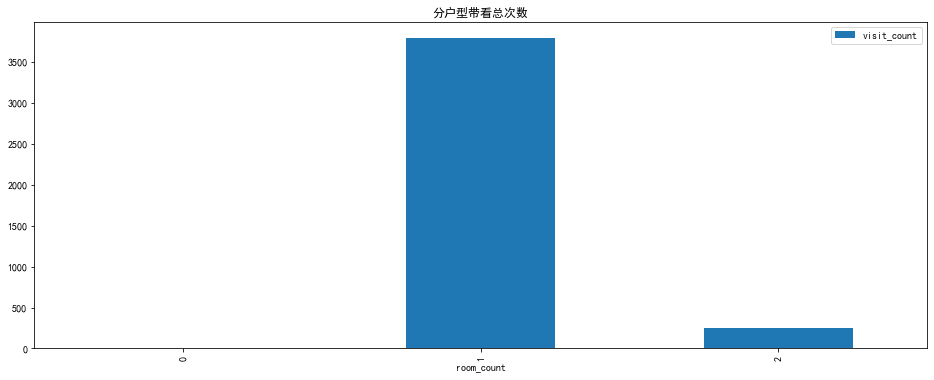

In [31]:
data.groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型带看总次数')

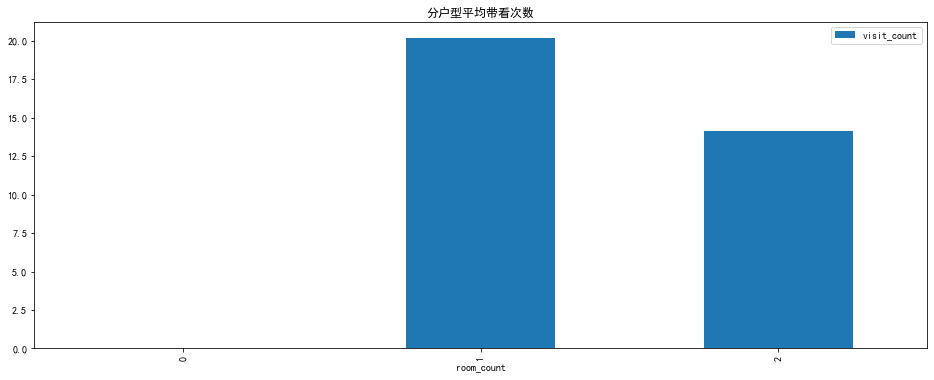

In [32]:
data.groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型平均带看次数')

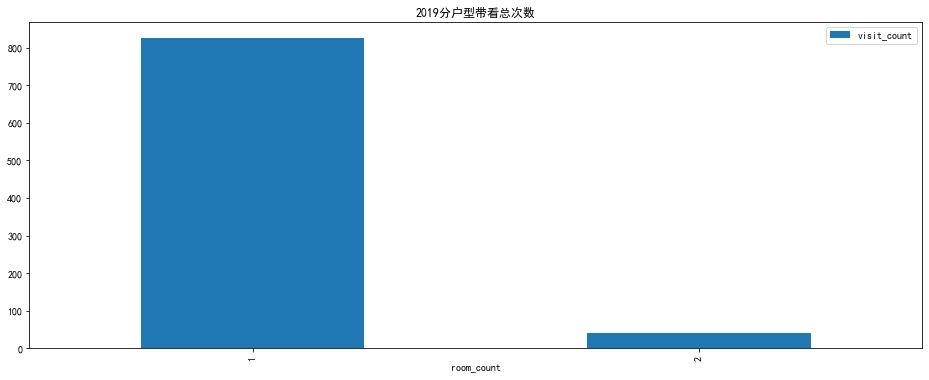

In [33]:
data[data['deal_date']>='2019'].groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型带看总次数')

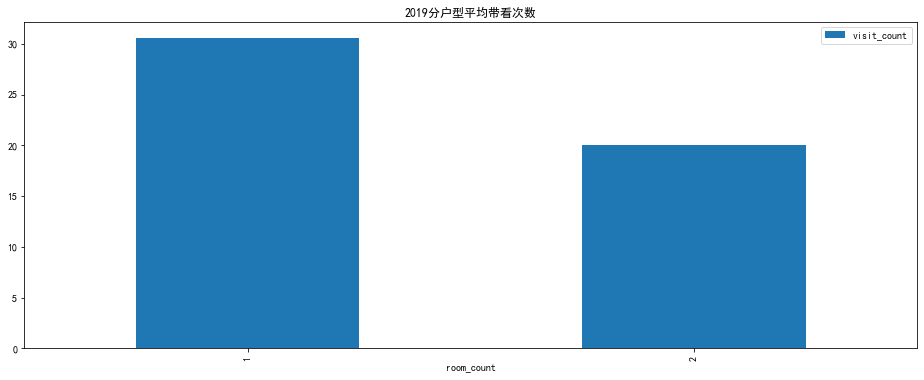

In [34]:
data[data['deal_date']>='2019'].groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型平均带看次数')

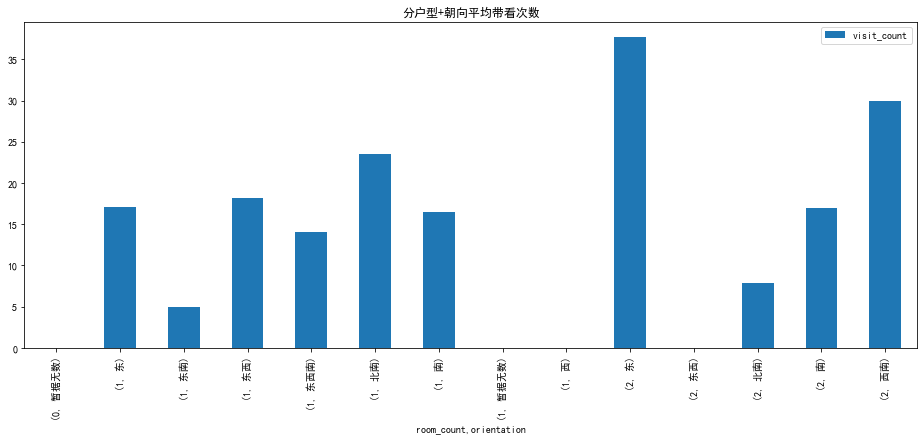

In [35]:
data.groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型+朝向平均带看次数')

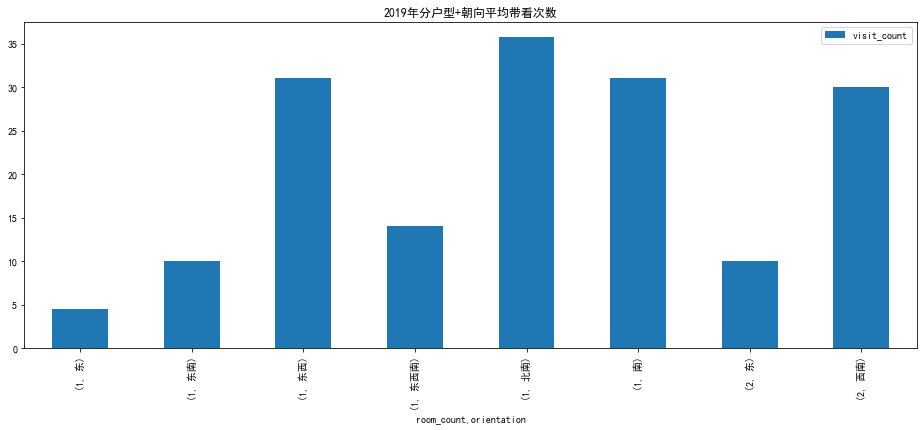

In [36]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019年分户型+朝向平均带看次数')

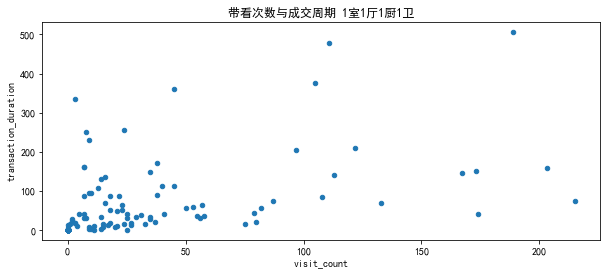

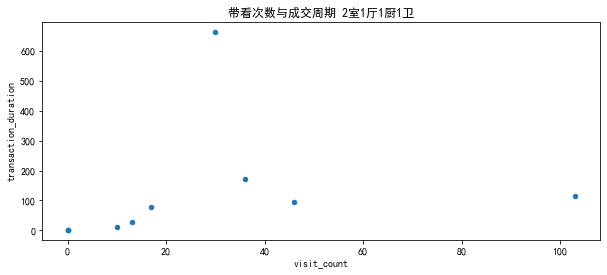

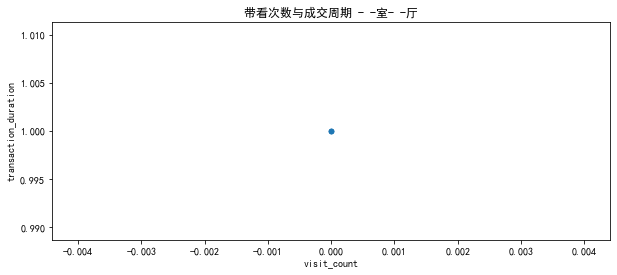

In [37]:
for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_duration','visit_count']].plot(kind='scatter',x='visit_count', y='transaction_duration',figsize=(10,4),title='带看次数与成交周期 '+t)

分户型成交周期分布

In [38]:
data.groupby(['room_count','orientation','floor']).describe()[['transaction_duration']]

transaction_duration                          \
                                               count        mean         std   
room_count orientation floor                                                   
0          暂据无数        中楼层(共6层)                  1.0    1.000000         NaN   
                       低楼层(共6层)                  1.0    1.000000         NaN   
                       底层(共6层)                   1.0    1.000000         NaN   
                       顶层(共6层)                   1.0    1.000000         NaN   
1          东           中楼层(共6层)                  5.0  132.200000   92.304929   
                       低楼层(共6层)                  1.0   31.000000         NaN   
                       顶层(共6层)                   2.0  188.500000  265.165043   
                       高楼层(共6层)                  2.0   35.500000    7.778175   
           东南          中楼层(共6层)                  2.0    4.000000    0.000000   
           东西          中楼层(共6层)                  1.0  159.000000         NaN   
                       低楼层(共6层)                  2.0   75.500000  105.358910   
                       底层(共6层)                   2.0   25.500000   34.648232   
                       顶层(共6层)                   2.0   31.000000   42.426407   
                       高楼层(共6层)                  5.0   79.000000  109.478308   
           东西南         高楼层(共6层)                  1.0   33.000000         NaN   
           北南          中楼层(共6层)                 30.0   28.700000   47.571471   
                       低楼层(共6层)                 12.0   63.583333   64.992948   
                       底层(共6层)                  10.0   59.300000   64.197698   
                       顶层(共6层)                  11.0  133.272727  189.993732   
                       高楼层(共6层)                 12.0   45.583333   94.443305   
           南           中楼层(共6层)                 14.0   21.357143   25.472782   
                       低楼层(共6层)                  3.0  123.666667  205.575615   
                       底层(共6层)                   5.0   19.800000   12.949903   
                       顶层(共6层)                   5.0   70.800000   60.919619   
                       高楼层(共6层)                  3.0   39.666667   43.650124   
           暂据无数        中楼层(共6层)                  0.0         NaN         NaN   
           西           顶层(共6层)                   0.0         NaN         NaN   
                       高楼层(共6层)                  1.0    1.000000         NaN   
2          东           中楼层(共6层)                  2.0   63.000000   74.953319   
                       底层(共6层)                   0.0         NaN         NaN   
           东西          顶层(共6层)                   1.0    1.000000         NaN   
           北南          中楼层(共6层)                  1.0    1.000000         NaN   
                       低楼层(共6层)                  0.0         NaN         NaN   
                       底层(共6层)                   3.0   89.000000   85.609579   
                       顶层(共6层)                   0.0         NaN         NaN   
                       高楼层(共6层)                  1.0   27.000000         NaN   
           南           顶层(共6层)                   1.0   79.000000         NaN   
           西南          中楼层(共6层)                  1.0  663.000000         NaN   

                                                                      
                                   min     25%    50%     75%    max  
room_count orientation floor                                          
0          暂据无数        中楼层(共6层)    1.0    1.00    1.0    1.00    1.0  
                       低楼层(共6层)    1.0    1.00    1.0    1.00    1.0  
                       底层(共6层)     1.0    1.00    1.0    1.00    1.0  
                       顶层(共6层)     1.0    1.00    1.0    1.00    1.0  
1          东           中楼层(共6层)    1.0   96.00  142.0  172.00  250.0  
                       低楼层(共6层)   31.0   31.00   31.0   31.00   31.0  
                       顶层(共6层)     1.0   94.75  188.5  282.25  376.0  
                       高楼层(共6层)   30.0   

tuple index out of range 2室1厅1厨1卫
tuple index out of range - -室- -厅


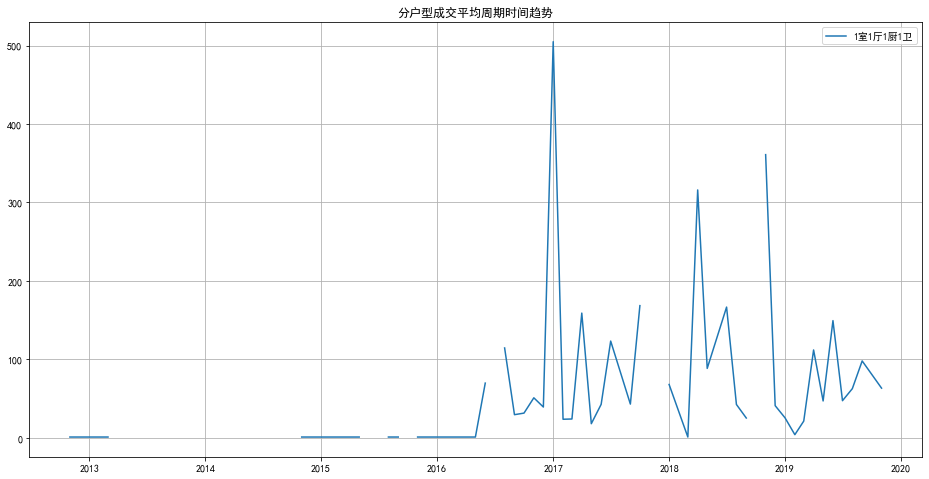

In [39]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    try:
        plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_duration'])
    except Exception as e:
        print(e,t)
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交平均周期时间趋势')
plt.show()

### 4) 成交量时间趋势

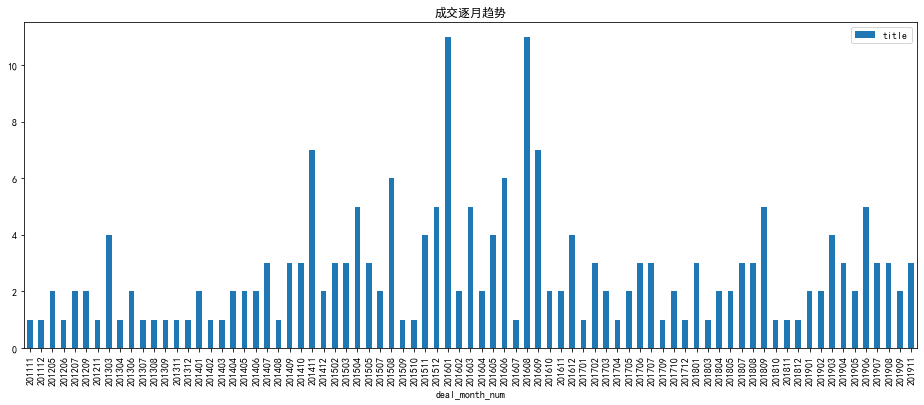

In [40]:
data.groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='成交逐月趋势')
#ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))

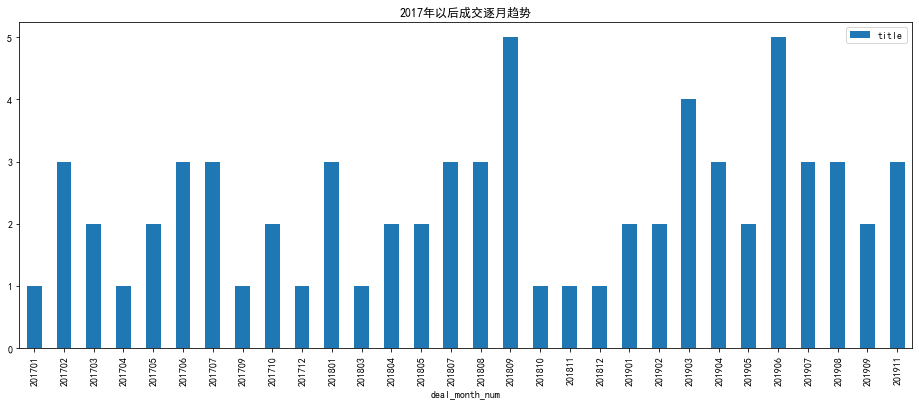

In [41]:
data[data['deal_date']>='2017'].groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='2017年以后成交逐月趋势')

## 2.2 价格机制

相同面积，房间数下，影响价格的因素主要是朝向和楼层

### 1）分户型平均成交价格走势

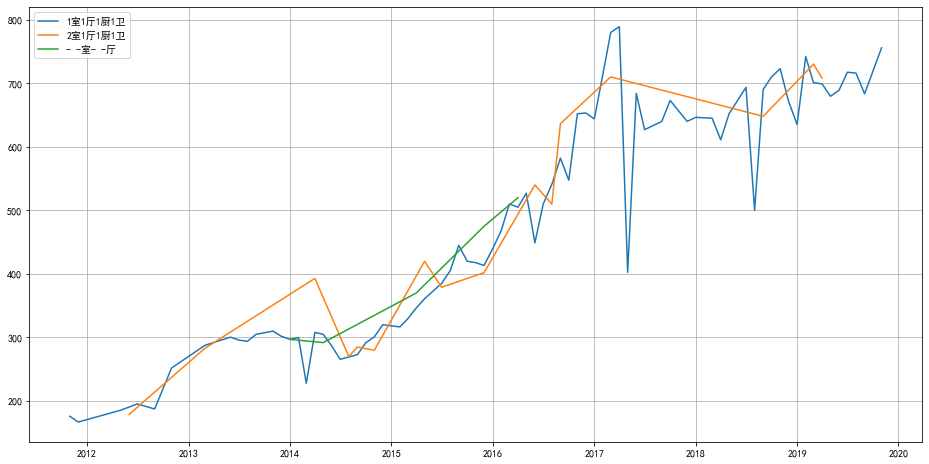

In [42]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.show()

### 2）2019年分户型不同楼层成交均价

In [43]:
data[data['deal_date']>'2019'].groupby(['house_type','area','floor', 'build_year'])[['transaction_price','per_area_price']].mean()

transaction_price  per_area_price
house_type area  floor    build_year                                   
1室1厅1厨1卫   50.92 中楼层(共6层) 2003                    722.0       14.179104
           51.01 顶层(共6层)  2003                    730.0       14.310919
                 高楼层(共6层) 2003                    687.0       13.467947
           51.25 高楼层(共6层) 2003                    680.0       13.268293
           51.37 低楼层(共6层) 2003                    719.0       13.996496
           51.77 中楼层(共6层) 2003                    703.0       13.579293
           51.78 中楼层(共6层) 2003                    695.0       13.422171
           51.87 中楼层(共6层) 2003                    696.0       13.418161
           51.96 底层(共6层)  2003                    680.0       13.086990
           52.20 中楼层(共6层) 2003                    708.0       13.563218
           52.21 低楼层(共6层) 2003                    702.0       13.445700
           52.33 中楼层(共6层) 2003                    687.5       13.137779
                 低楼层(共6层) 2003                    720.0       13.758838
           52.51 高楼层(共6层) 2003                    645.0       12.283375
           53.71 高楼层(共6层) 2003                    685.0       12.753677
           54.20 高楼层(共6层) 2003                    670.0       12.361624
           54.42 高楼层(共6层) 2003                    720.0       13.230430
           54.66 中楼层(共6层) 2003                    730.0       13.355287
                 底层(共6层)  2003                    725.0       13.263813
           55.17 中楼层(共6层) 2003                    705.0       12.778684
           56.16 中楼层(共6层) 2003                    789.0       14.049145
           56.37 高楼层(共6层) 2003                    710.0       12.595352
           56.96 顶层(共6层)  2003                    689.0       12.096208
           60.15 中楼层(共6层) 2003                    815.0       13.549460
2室1厅1厨1卫   54.95 中楼层(共6层) 2003                    730.0       13.284804
           63.47 中楼层(共6层) 2003                    708.0       11.154876

### 3）各个户型最后成交价格

户型锚定价格

In [44]:
data.sort_values('deal_date').groupby(['house_type','area','floor'])[['transaction_price','deal_date']].last()

transaction_price  deal_date
house_type area  floor                                 
- -室- -厅   51.01 顶层(共6层)                 292 2014-05-01
           51.25 底层(共6层)                 297 2014-01-01
           54.77 中楼层(共6层)                475 2015-12-01
           58.25 底层(共6层)                 520 2016-04-01
           63.82 低楼层(共6层)                370 2015-04-01
1室1厅1厨1卫   40.87 低楼层(共6层)                590 2019-01-01
           40.93 底层(共6层)                 228 2014-03-23
           50.15 底层(共6层)                 500 2016-10-11
           50.92 中楼层(共6层)                722 2019-11-05
                 低楼层(共6层)                636 2018-08-01
                 底层(共6层)                 508 2016-08-25
                 顶层(共6层)                 292 2013-04-05
                 高楼层(共6层)                310 2014-11-23
           51.01 中楼层(共6层)                310 2013-11-07
                 顶层(共6层)                 730 2019-11-01
                 高楼层(共6层)                687 2019-09-03
           51.15 低楼层(共6层)                645 2017-06-14
                 底层(共6层)                 414 2016-01-14
           51.16 中楼层(共6层)                167 2011-12-03
           51.18 顶层(共6层)                 480 2016-03-13
                 高楼层(共6层)                506 2016-08-21
           51.25 中楼层(共6层)                660 2018-09-01
                 低楼层(共6层)                285 2013-03-04
                 底层(共6层)                 410 2015-11-29
                 高楼层(共6层)                680 2019-01-10
           51.37 中楼层(共6层)                640 2017-12-01
                 低楼层(共6层)                719 2019-07-09
           51.67 底层(共6层)                 400 2015-08-01
           51.70 中楼层(共6层)                297 2014-01-22
                 底层(共6层)                 305 2013-09-08
                 高楼层(共6层)                320 2014-11-01
           51.77 中楼层(共6层)                708 2019-08-01
                 低楼层(共6层)                420 2015-12-01
                 底层(共6层)                 510 2016-08-10
                 高楼层(共6层)                611 2017-07-09
           51.78 中楼层(共6层)                695 2019-02-18
                 顶层(共6层)                 237 2014-07-06
                 高楼层(共6层)                288 2014-10-17
           51.87 中楼层(共6层)                696 2019-03-01
                 低楼层(共6层)                630 2017-07-18
                 底层(共6层)                 282 2014-07-03
                 高楼层(共6层)                442 2016-01-25
           51.96 中楼层(共6层)                420 2015-12-01
                 底层(共6层)                 680 2019-09-15
                 顶层(共6层)                 670 2018-09-01
                 高楼层(共6层)                420 2016-01-01
           52.00 底层(共6层)                 565 2016-08-01
           52.06 顶层(共6层)                 710 2018-07-01
           52.11 中楼层(共6层)                710 2017-06-01
                 高楼层(共6层)                639 2018-05-02
           52.20 中楼层(共6层)                708 2019-07-15
           52.21 中楼层(共6层)                288 2014-10-25
                 低楼层(共6层)                702 2019-03-03
                 底层(共6层)                 635 2016-12-22
           52.33 中楼层(共6层)                675 2019-06-02
                 低楼层(共6层)                720 2019-08-12
                 高楼层(共6层)                203 2012-07-22
           52.51 高楼层(共6层)                645 2019-06-01
           52.61 顶层(共6层)                 705 2017-02-14
           52.63 低楼层(共6层)                300 2013-03-06
                 高楼层(共6层)                398 2015-08-07
           52.64 中楼层(共6层)                658 2018-01-01
           52.74 中楼层(共6层)                645 2016-11-25
                 低楼层(共6层)                640 2017-07-12
                 底层(共6层)                 410 2015-08-20
                 高楼层(共6层)                420 2015-11-16
           53.44 中楼层(共6层)                646 2018-01-15
                 低楼层(共6层)                278 2014-07-04
           53.71 高楼层(共6层)                685 2019-06-12
           53.83 中楼层(共6层)                330 2015-0

### 4）分户型楼层以及时间，挂牌价与成交价gap分布

In [45]:
#data.groupby(['house_type','area','floor','deal_year'])[['transaction_listed_price_gap']].describe()
data.groupby(['house_type','deal_year'])[['transaction_listed_price_gap']].describe()

transaction_listed_price_gap                        \
                                             count       mean        std   
house_type deal_year                                                       
- -室- -厅   2014-01-01                          0.0        NaN        NaN   
           2015-01-01                          0.0        NaN        NaN   
           2016-01-01                          0.0        NaN        NaN   
1室1厅1厨1卫   2011-01-01                          2.0  -7.000000   5.656854   
           2012-01-01                          7.0 -16.285714  30.296943   
           2013-01-01                         11.0  -7.000000  11.541230   
           2014-01-01                         22.0  -2.500000   7.781235   
           2015-01-01                         28.0  -7.357143   6.447591   
           2016-01-01                         50.0  -5.120000   6.251987   
           2017-01-01                         18.0 -23.611111  27.437928   
           2018-01-01                         19.0 -19.105263  15.201954   
           2019-01-01                         27.0 -23.925926  17.763242   
2室1厅1厨1卫   2012-01-01                          1.0  -1.000000        NaN   
           2013-01-01                          1.0 -17.000000        NaN   
           2014-01-01                          5.0  -2.000000   4.472136   
           2015-01-01                          3.0   0.333333  17.387735   
           2016-01-01                          4.0  -5.500000   6.658328   
           2017-01-01                          1.0 -15.000000        NaN   
           2018-01-01                          1.0 -22.000000        NaN   
           2019-01-01                          2.0 -41.500000  16.263456   

                                                       
                        min    25%   50%    75%   max  
house_type deal_year                                   
- -室- -厅   2014-01-01   NaN    NaN   NaN    NaN   NaN  
           2015-01-01   NaN    NaN   NaN    NaN   NaN  
           2016-01-01   NaN    NaN   NaN    NaN   NaN  
1室1厅1厨1卫   2011-01-01 -11.0  -9.00  -7.0  -5.00  -3.0  
           2012-01-01 -84.0 -10.00  -5.0  -3.50   2.0  
           2013-01-01 -32.0  -4.50  -3.0   0.00   0.0  
           2014-01-01 -28.0  -5.00   0.0   0.00  15.0  
           2015-01-01 -20.0 -12.00  -6.5  -4.75   5.0  
           2016-01-01 -30.0  -9.00  -5.0   0.00   3.0  
           2017-01-01 -99.0 -33.00 -15.0  -3.75   0.0  
           2018-01-01 -50.0 -26.50 -15.0 -10.00  10.0  
           2019-01-01 -97.0 -28.50 -21.0 -13.00  -6.0  
2室1厅1厨1卫   2012-01-01  -1.0  -1.00  -1.0  -1.00  -1.0  
           2013-01-01 -17.0 -17.00 -17.0 -17.00 -17.0  
           2014-01-01 -10.0   0.00   0.0   0.00   0.0  
           2015-01-01 -13.0  -9.50  -6.0   7.00  20.0  
           2016-01-01 -15.0  -7.50  -3.5  -1.50   0.0  
           2017-01-01 -15.0 -15.00 -15.0 -15.00 -15.0  
           2018-01-01 -22.0 -22.00 -22.0 -22.00 -22.0  
           2019-01-01 -53.0 -47.25 -41.5 -35.75 -30.0

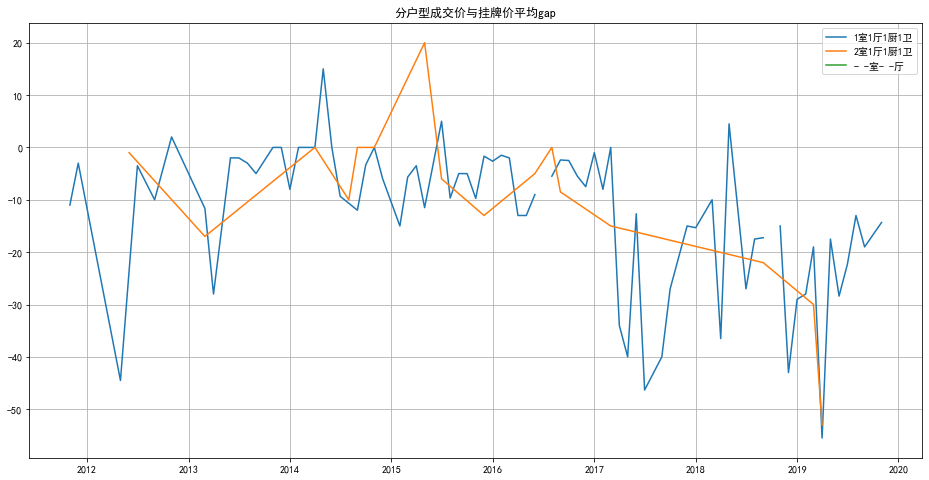

In [46]:
#plt.figure(figsize=(16, 8))
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交价与挂牌价平均gap')
plt.show()

D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


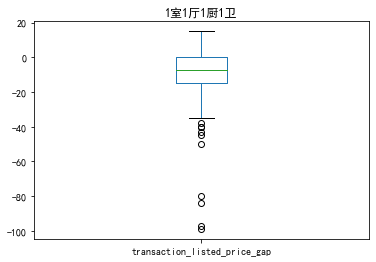

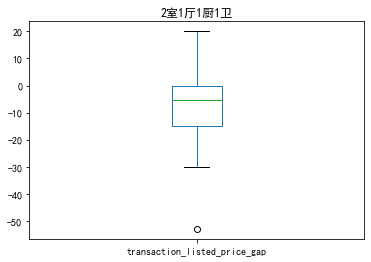

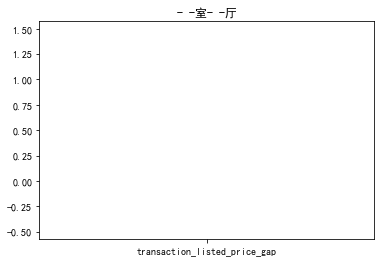

In [47]:

for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_listed_price_gap']].plot(kind='box', title=t)


In [48]:
#pd.plotting.scatter_matrix(data['transaction_duration','visit_count'], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#import matplotlib.pyplot as plt
#transaction_duration=data['transaction_duration']
#plt.figure(figsize=(20, 5))
#for i, col in enumerate(['visit_count']):
#    plt.subplot(1, 3, i+1)
#    plt.plot(data[col], transaction_duration, 'o')
#    plt.title(col)
#    plt.xlabel(col)
#plt.ylabel('transaction_duration')

### 5) 候选目标户型价格分析

In [49]:
candidate = data[(abs((data['area']-55))<=1) & (data['deal_year']>='2017')]

In [50]:
candidate.groupby('floor').count()[['title']]

,title
floor,
中楼层(共6层),9
低楼层(共6层),2
底层(共6层),4
顶层(共6层),2
高楼层(共6层),4


In [51]:
candidate[['title','deal_month', 'floor', 'transaction_price']].sort_values('deal_month').head(100)

,title,deal_month,floor,transaction_price
71,教场口6号院 1室1厅 54.42平米,2017-02-01,低楼层(共6层),749
74,教场口6号院 1室1厅 54.77平米,2017-03-01,底层(共6层),780
89,教场口6号院 1室1厅 54.42平米,2017-05-01,顶层(共6层),660
88,教场口6号院 1室1厅 55.17平米,2017-05-01,中楼层(共6层),145
47,教场口6号院 1室1厅 54.42平米,2017-06-01,中楼层(共6层),697
53,教场口6号院 1室1厅 54.77平米,2017-10-01,高楼层(共6层),675
57,教场口6号院 1室1厅 54.42平米,2018-05-01,顶层(共6层),665
31,教场口6号院 1室1厅 54.77平米,2018-07-01,底层(共6层),703
32,教场口6号院 1室1厅 54平米,2018-08-01,中楼层(共6层),157
34,教场口6号院 1室1厅 54.66平米,2018-08-01,底层(共6层),707


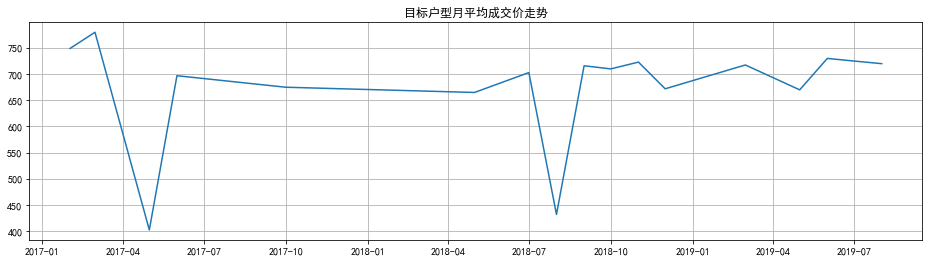

In [52]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
plt.plot(candidate.groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.title('目标户型月平均成交价走势')
plt.show()

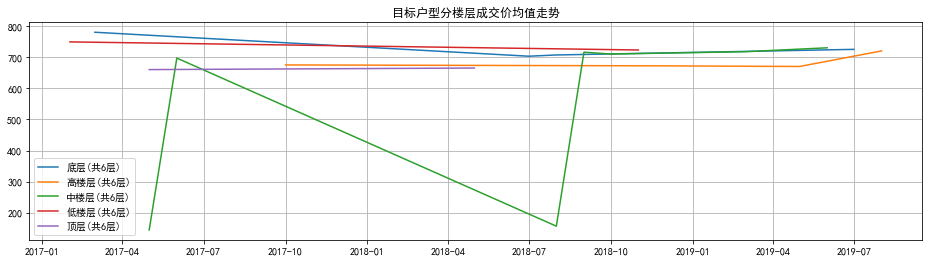

In [53]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[candidate['floor']==t].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('目标户型分楼层成交价均值走势')
plt.show()

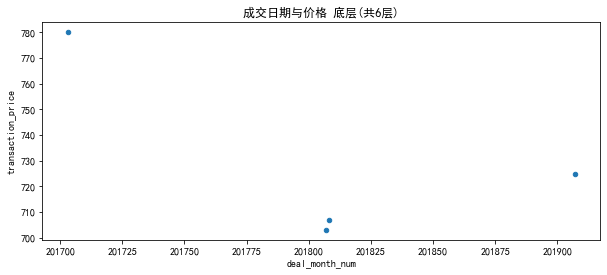

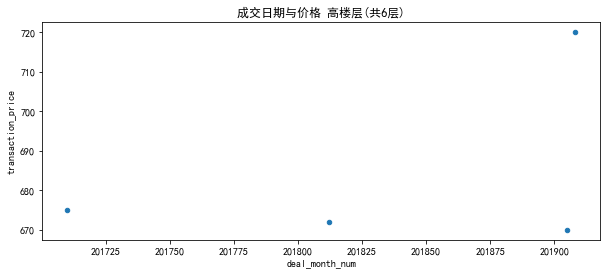

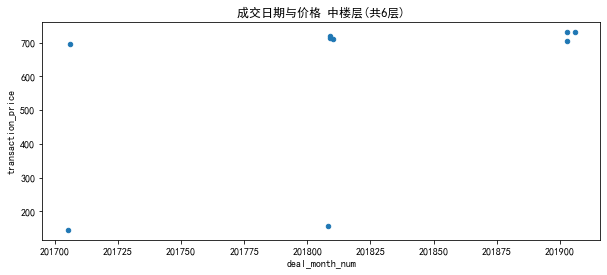

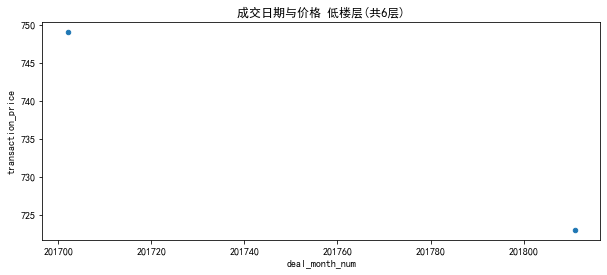

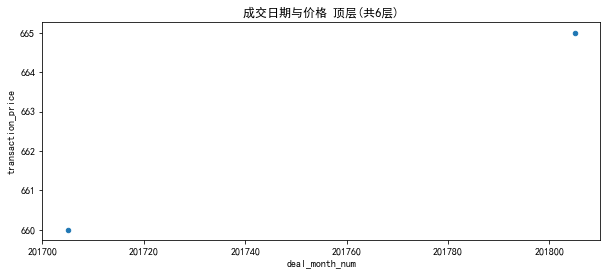

In [54]:
for t in candidate['floor'].unique():
    ax=candidate[candidate['floor']==t][['transaction_price','deal_month_num']].plot(kind='scatter',x='deal_month_num', y='transaction_price',figsize=(10,4),title='成交日期与价格 '+t)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

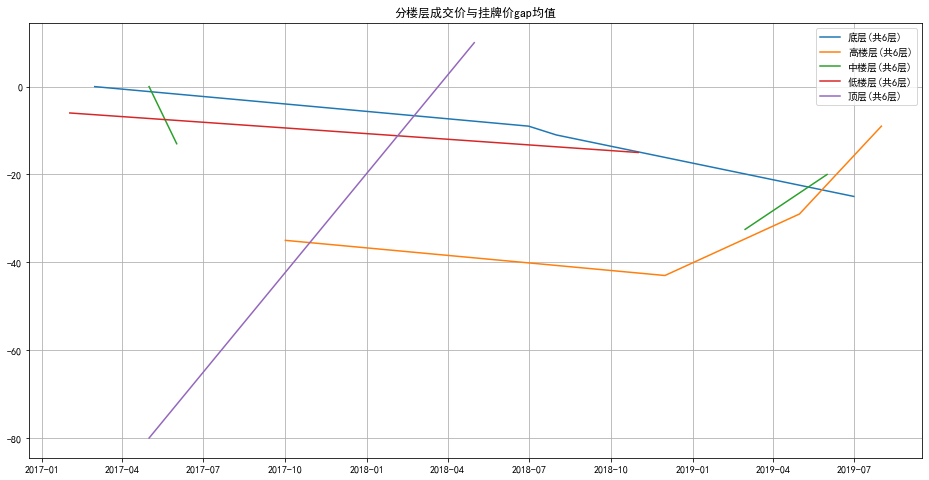

In [55]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[candidate['floor']==t].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('分楼层成交价与挂牌价gap均值')
plt.show()

价格gap线框图分布

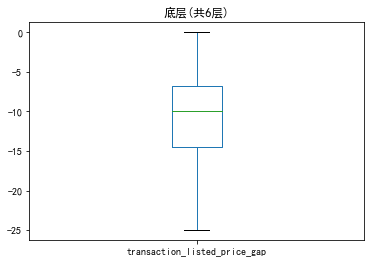

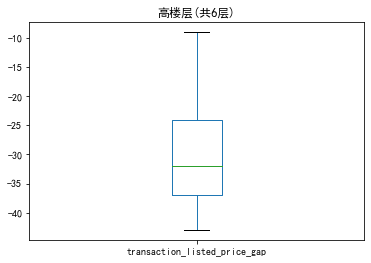

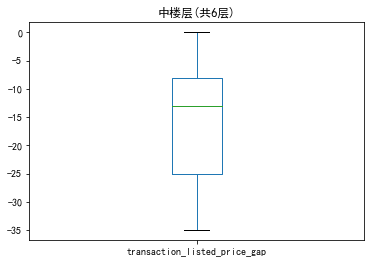

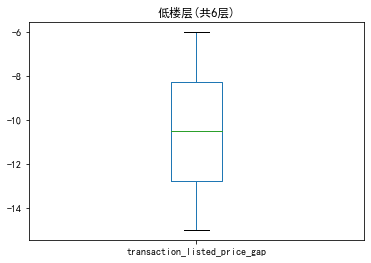

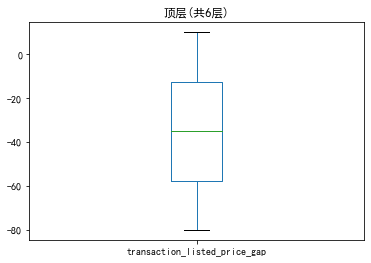

In [56]:
for t in candidate['floor'].unique():
    candidate[candidate['floor']==t][['transaction_listed_price_gap']].plot(kind='box', title=t)
